In [ ]:
!pip install torch transformers datasets scikit-learn pandas openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd

file_path = "/content/insta_data.xlsx"
df = pd.read_excel(file_path)

df = df[["Post Description", "Sentiment"]].dropna()

print(df.head(), df["Sentiment"].value_counts())


                                    Post Description Sentiment
0  देश में 24 घंटे में 127 मौतें और 3277 नए केस, ...  negative
1  In the last 24 hours, 128 deaths, 1511 dischar...  positive
2  कोरोनाशी लढण्याचा KJ पॅटर्न !\n\n@rohit_rajend...  negative
3  #swahiliforummediaUPDATES \n#CORONAVIRUSUPDATE...   neutral
4  Mrs. Chaitali Chavarkar misses being at home e...  positive Sentiment
neutral     47399
positive    36800
negative    15802
Name: count, dtype: int64


In [ ]:
sentiment_mapping = {"positive": 0, "neutral": 1, "negative": 2}
df["Sentiment"] = df["Sentiment"].map(sentiment_mapping)


In [ ]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["Post Description"] = df["Post Description"].apply(preprocess_text)


In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Post Description"], df["Sentiment"], test_size=0.2, random_state=42
)


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, list(train_labels))
test_dataset = SentimentDataset(test_encodings, list(test_labels))


In [ ]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)
model.to("cuda")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=2e-5)

num_training_steps = len(train_loader) * 6
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


In [ ]:
train_loss_history = []
train_accuracy_history = []
error_rate_history = []

def train_model_with_tracking(model, dataloader, optimizer, scheduler, num_epochs=6):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct, total = 0, 0

        for batch in dataloader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            labels = batch["labels"].to("cuda")

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            correct += (outputs.logits.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(dataloader)
        accuracy = correct / total
        error_rate = 1 - accuracy

        train_loss_history.append(avg_loss)
        train_accuracy_history.append(accuracy)
        error_rate_history.append(error_rate)

        print(f"Epoch {epoch + 1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy * 100:.2f}%")


In [ ]:
train_model_with_tracking(model, train_loader, optimizer, lr_scheduler, num_epochs=6)


Epoch 1: Loss = 0.4108, Accuracy = 84.90%
Epoch 2: Loss = 0.2636, Accuracy = 90.77%
Epoch 3: Loss = 0.1968, Accuracy = 93.22%
Epoch 4: Loss = 0.1422, Accuracy = 95.08%
Epoch 5: Loss = 0.1025, Accuracy = 96.44%
Epoch 6: Loss = 0.0738, Accuracy = 97.53%


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)



In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_model_with_metrics(model, dataloader):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            labels = batch["labels"].to("cuda")

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(logits.cpu().numpy())


    class_labels = ["positive", "neutral", "negative"]
    print("📊 Accuracy per Class:")
    for i, label in enumerate(class_labels):
        class_total = sum(1 for y in y_true if y == i)
        class_correct = sum(1 for y, p in zip(y_true, y_pred) if y == i and y == p)
        class_acc = (class_correct / class_total) * 100 if class_total > 0 else 0
        print(f"  • {label.capitalize()}: {class_acc:.2f}%")


    overall_accuracy = accuracy_score(y_true, y_pred) * 100
    print(f"\n✅ Overall Accuracy: {overall_accuracy:.2f}%")


    print("\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


    y_true_bin = np.eye(3)[y_true]
    y_scores = np.array(y_scores)
    for i, label in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc(fpr, tpr):.2f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    specificity = np.mean([
        cm[i, i] / (cm[:, i].sum() + cm[i, :].sum() - 2 * cm[i, i])
        if (cm[:, i].sum() + cm[i, :].sum() - 2 * cm[i, i]) != 0 else 0
        for i in range(3)
    ])

    print(f"\n🎯 Macro Precision: {precision:.4f}")
    print(f"📈 Macro Recall (Sensitivity): {recall:.4f}")
    print(f"💥 Macro F1 Score: {f1:.4f}")
    print(f"🧠 Macro Specificity (approx): {specificity:.4f}")


📊 Accuracy per Class:
  • Positive: 94.34%
  • Neutral: 93.01%
  • Negative: 76.60%

✅ Overall Accuracy: 90.92%

📋 Classification Report:
              precision    recall  f1-score   support

    positive       0.93      0.94      0.94      7381
     neutral       0.92      0.93      0.93      9479
    negative       0.81      0.77      0.79      3141

    accuracy                           0.91     20001
   macro avg       0.89      0.88      0.88     20001
weighted avg       0.91      0.91      0.91     20001



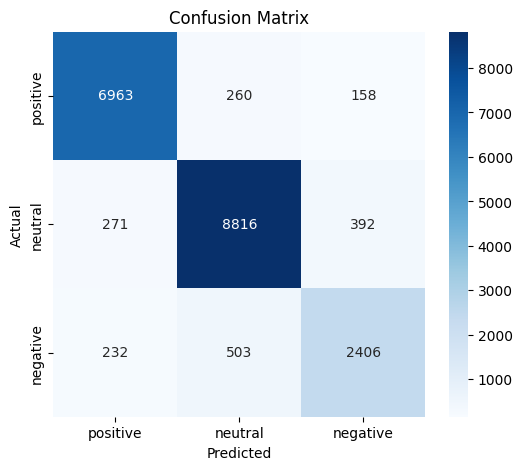

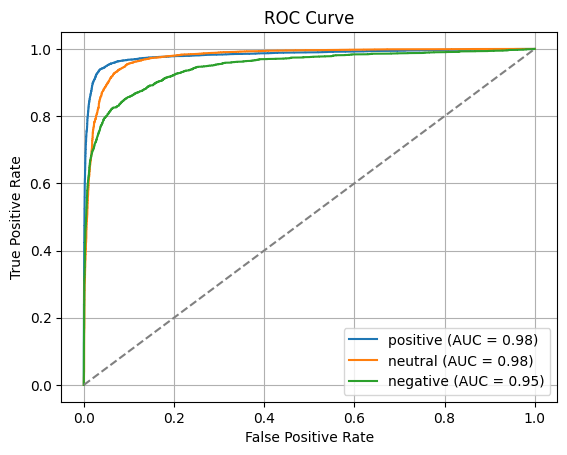


🎯 Macro Precision: 0.8890
📈 Macro Recall (Sensitivity): 0.8798
💥 Macro F1 Score: 0.8841
🧠 Macro Specificity (approx): 5.2050


In [ ]:
evaluate_model_with_metrics(model, test_loader)
